![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - Weather-Induced Extremes Digital Twin - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)

<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [6]:
pip install --quiet --upgrade destinelab

Note: you may need to restart the kernel to use updated packages.


In [7]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import json
import os
from getpass import getpass
import destinelab as deauth

In [9]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [10]:
auth.is_DTaccess_allowed(access_token)

DT Output access allowed


True

### Query using the DEDL HDA API


### Filter
We have to setup up a filter and define which data to obtain.

Extreme DT data is available for specific time ranges around the current date.

It is possible to use the ECMWF Aviso package to check data availability (see the xtremeDT-dataAvailability notebook in this folder) and change accordingly the 'datechoice' variable in the cell below.

In [11]:
datechoice = "2024-12-11T00:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed (rd or d1)
        "dataset": "extremes-dt",  # fixed extreme dt 
        "expver": "0001",          # fixed experiment version 
        "stream": "oper",          # fixed oper
        "step": "0",               # Forcast step hourly (1..96)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "31"             # Surface Pressure parameter
    }.items()
}

## Make Data Request

In [12]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)
response = session.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.DT_EXTREMES always return a single item containing all the requested data
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
product["id"]
#product

'DT_EXTREMES_20241211_20241211_cb5e48476d60a083cf0eaa38f6bb29f5ee0575d6'

## Submission worked ? Once our product found, we download the data.

In [13]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]

HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = session.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
elif (response.status_code != HTTP_ACCEPTED_CODE):
    print(response.text)

response.raise_for_status()    
print(download_url)  

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20241211_20241211_cb5e48476d60a083cf0eaa38f6bb29f5ee0575d6/download?provider=dedt_lumi&_dc_qs=%257B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522extremes-dt%2522%252C%2B%2522date%2522%253A%2B%252220241211%252Fto%252F20241211%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522param%2522%253A%2B31%252C%2B%2522step%2522%253A%2B0%252C%2B%2522stream%2522%253A%2B%2522oper%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [14]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = session.get(url, headers=auth_headers, stream=True)

if (response.status_code not in (HTTP_SUCCESS_CODE,HTTP_ACCEPTED_CODE)):
     (print(response.text))
        
# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response)
    print(response.text)
    raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading 4307a7a1-6a03-4ed0-89f8-3f5d92729b65.grib


100%|██████████| 3.44M/3.44M [00:00<00:00, 19.7MB/s]


## Render the sea ice coverage on a map

Lets plot the result file

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [15]:
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import numpy as np

ds = xr.load_dataset(filename, engine="cfgrib")

ds

<xarray.Dataset>
Dimensions:     (values: 26306560)
Coordinates:
    time        datetime64[ns] 2024-12-11
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.97 89.97 89.97 ... -89.97 -89.97 -89.97
    longitude   (values) float64 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
    valid_time  datetime64[ns] 2024-12-11
Dimensions without coordinates: values
Data variables:
    siconc      (values) float32 0.9949 0.995 0.995 0.9951 ... 0.0 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-12T15:45 GRIB to CDM+CF via cfgrib-0.9.1...

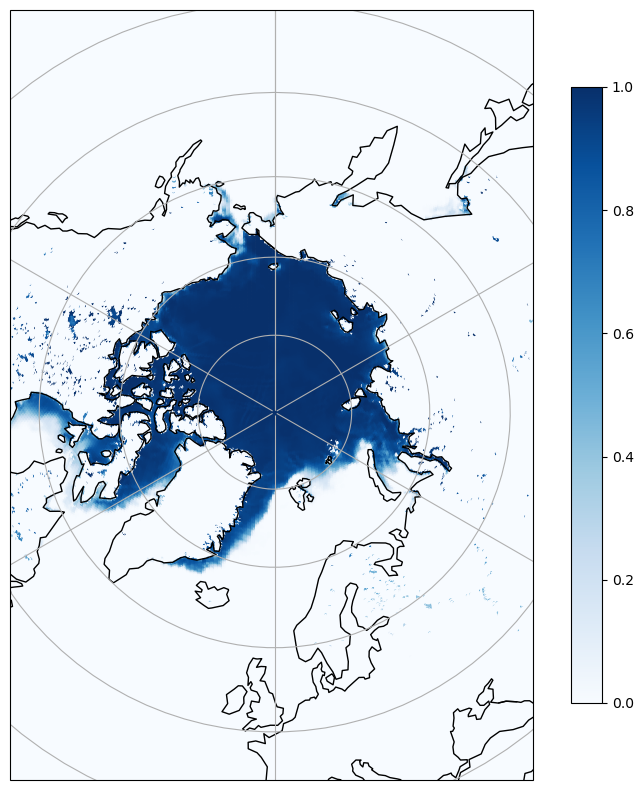

In [16]:
import cartopy.crs as crs
import cartopy.feature as cfeature

fig = plt.figure(figsize=[10, 10])

#ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
crs_epsg=crs.NorthPolarStereo(central_longitude=0)
ax = fig.add_subplot(1,1,1, projection=crs_epsg)

ax.set_extent([-3850000.0, 3750000.0, -5350000, 5850000.0],crs_epsg)

ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

cs = plt.scatter(x=ds.longitude[::10], y=ds.latitude.data[::10], c=ds.siconc[::10], cmap="Blues",
            s=1,
            transform=crs.PlateCarree())

fig.colorbar(cs, ax=ax, location='right', shrink =0.8)
plt.show()